/anaconda/envs/Edward/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


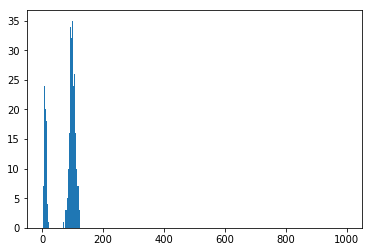

numpy.ndarray

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
from edward.models import (Categorical, Dirichlet, Empirical, Poisson,
                           Mixture, Gamma, ParamMixture, Normal,
                           InverseGamma, MultivariateNormalDiag)

#DATA
N = 1000
_lambda_0 = 10.0
_lambda_1 = 100.0
sess = ed.get_session()

dCat= Categorical([0.1, 0.99])
dPoi_0 = Poisson(_lambda_0)
dPoi_1 = Poisson(_lambda_1)

_x = Mixture(
    cat=dCat,
    components=[dPoi_0, dPoi_1]
)

x_data = sess.run(_x.sample(N))

plt.hist(x_data, bins=1000, range=(0, 1000))
plt.show()

display(type(x_data))
sess.close()
tf.flags.DEFINE_string('f', '', 'kernel')

In [2]:
from IPython.display import clear_output

K = 2

# with tf.Graph().as_default():
sess = ed.get_session()
FLAGS = tf.flags.FLAGS

pi = Dirichlet(
    tf.ones(K),
    name="pi"
)
c= Categorical(
    pi,
    name="c"
)
g0 = Gamma(
    concentration=70.0,
    rate=1.0,
    name="g0"
)
g1 = Gamma(
    concentration=140.0,
    rate=1.0,
    name="g1"
)
p0 = Poisson(
    g0,
    name="p0"
)
p1 = Poisson(
    g1,
    name="p0"
)

x = Mixture(
    cat=c,
    components=[p0, p1],
    sample_shape=N,
    name="x"
)

qpi = Dirichlet(
    tf.nn.softplus(
      tf.get_variable("qpi/concentration", [K])
    ),
    name="qpi"
)
qg0 = Gamma(
    concentration=tf.nn.softplus(tf.get_variable("qp0_c/loc", [])),
    rate=tf.nn.softplus(tf.get_variable("qp0_r/loc", [])),
    name="qg0"
)
qg1 = Gamma(
    concentration=tf.nn.softplus(tf.get_variable("qp1_c/loc", [])),
    rate=tf.nn.softplus(tf.get_variable("qp1_r/loc", [])),
    name="qg1"
)

inference = ed.KLqp(
    {
        pi: qpi,
        g0: qg0,
        g1: qg1,
    },
    data={
        x: x_data
    }
)

inference.initialize(n_iter=10000)

tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
display(inference.n_iter)
for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
inference.finalize()


/anaconda/envs/Edward/lib/python3.5/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


10000

  100/10000 [  1%]                                ETA: 72s | Loss: 13991.100   
Inferred cluster means:
  200/10000 [  2%]                                ETA: 41s | Loss: 19504.092
Inferred cluster means:
  300/10000 [  3%]                                ETA: 30s | Loss: 8564.684 
Inferred cluster means:
  400/10000 [  4%] █                              ETA: 24s | Loss: 23308.393
Inferred cluster means:
  500/10000 [  5%] █                              ETA: 21s | Loss: 81510.367
Inferred cluster means:
  600/10000 [  6%] █                              ETA: 19s | Loss: 26107.486
Inferred cluster means:
  700/10000 [  7%] ██                             ETA: 17s | Loss: 18379.412
Inferred cluster means:
  800/10000 [  8%] ██                             ETA: 16s | Loss: 12105.320
Inferred cluster means:
  900/10000 [  9%] ██                             ETA: 15s | Loss: 35393.062
Inferred cluster means:
 1000/10000 [ 10%] ███                            ETA: 14s | Loss: 16705.805
Inferred cl

 8300/10000 [ 83%] ████████████████████████       ETA: 1s | Loss: 5639.533
Inferred cluster means:
 8400/10000 [ 84%] █████████████████████████      ETA: 1s | Loss: 5773.655
Inferred cluster means:
 8500/10000 [ 85%] █████████████████████████      ETA: 1s | Loss: 29813.533
Inferred cluster means:
 8600/10000 [ 86%] █████████████████████████      ETA: 1s | Loss: 4734.079 
Inferred cluster means:
 8700/10000 [ 87%] ██████████████████████████     ETA: 1s | Loss: 5308.618
Inferred cluster means:
 8800/10000 [ 88%] ██████████████████████████     ETA: 1s | Loss: 4335.431
Inferred cluster means:
 8900/10000 [ 89%] ██████████████████████████     ETA: 1s | Loss: 4921.160
Inferred cluster means:
 9000/10000 [ 90%] ███████████████████████████    ETA: 1s | Loss: 4924.938
Inferred cluster means:
 9100/10000 [ 91%] ███████████████████████████    ETA: 0s | Loss: 4330.145
Inferred cluster means:
 9200/10000 [ 92%] ███████████████████████████    ETA: 0s | Loss: 4570.309
Inferred cluster means:
 9300/10

In [3]:
display(qpi.sample(1000).eval().mean(axis=0))
display(qg0.sample(1000).eval().mean())
display(qg1.sample(1000).eval().mean())

array([0.551169  , 0.44883096], dtype=float32)

100.977295

12.484091

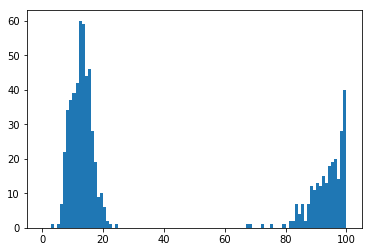

In [4]:
_qpi = qpi.sample(1000).eval().mean(axis=0)
qdCat= Categorical(_qpi)
qdPoi_0 = Poisson(qg0.sample(1000).eval().mean())
qdPoi_1 = Poisson(qg1.sample(1000).eval().mean())

q_x = Mixture(
    cat=qdCat,
    components=[qdPoi_0, qdPoi_1],
    sample_shape=N
)


plt.hist(q_x.eval(), bins=100, range=(0, 100))
plt.show()

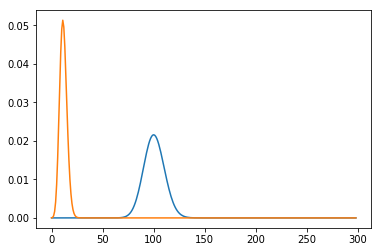

0.9999932

In [5]:
y_0 = qdPoi_0.prob(np.arange(1, 300).astype(np.float32)).eval() * _qpi[0]
y_1 = qdPoi_1.prob(np.arange(1, 300).astype(np.float32)).eval() * _qpi[1]
y_x = q_x.prob(np.arange(1, 300).astype(np.float32)).eval()

plt.plot(y_0)
plt.plot(y_1)
plt.show()

(y_0 + y_1).sum()

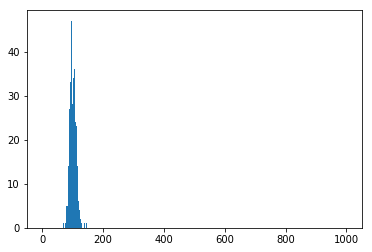

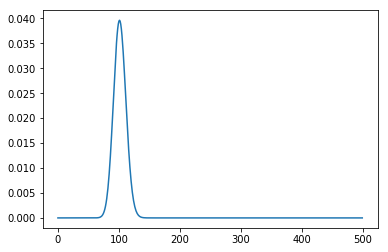

In [6]:
plt.hist(qdPoi_0.sample(1000).eval(), bins=1000, range=(0, 1000))
plt.show()

plt.plot(qdPoi_0.prob(np.arange(0, 500).astype(np.float32)).eval())
plt.show()

In [7]:
_qpi[0]

0.5452018

In [8]:
_qpi[1]

0.4547982